In [822]:
import numpy as np
import random
from sklearn import linear_model
import matplotlib.pyplot as plt
import pandas as pd

- sk=0: using_sklearn=False, sk=1: using_sklearn=True
- modele_gen=lineaire, sin ou tanh
- nb_train: nombre de donnees d'entrainement
- nb_test: nombre de donnees de test
- bruit: amplitude du bruit appliqué aux données
- M: degré du polynome de la fonction de base (recherche d'hyperparametre lorsque M<0) 
- lambda: lambda utilisé par le modele de Ridge ( learning rate)

In [1088]:
skl = 1
modele_gen = "sin"
nb_train = 80
nb_test = 20
bruit = 0.3 # dispersion
m = 20
lamb = 0.05 # learning rate
w = [0.3, 4.1]  # Parametres du modele generatif

### Gestion Donnees

In [1071]:
def generer_donnees():
    """
    Fonction qui genere des donnees de test et d'entrainement.

    modele_gen : 'lineaire', 'sin' ou 'tanh'
    nb_train : nb de donnees d'entrainement
    nb_test : nb de donnees de test
    bruit : amplitude du bruit (superieur ou egale a zero
    """
    np.random.seed(nb_train)
    x_train = np.random.rand(nb_train)
    x_test = np.random.rand(nb_test)
    if modele_gen == 'lineaire':
        t_train = w[0] + x_train * w[1] + np.random.randn(nb_train) * bruit
        t_test = w[0] + x_test * w[1] + np.random.randn(nb_test) * bruit
    elif modele_gen == 'sin':
        t_train = np.sin(x_train * w[1] * 2) + np.random.randn(nb_train) * bruit
        t_test = np.sin(x_test * w[1] * 2) + np.random.randn(nb_test) * bruit
    else:
        t_train = np.tanh((x_train - 0.5) * w[1] * 2) + np.random.randn(nb_train) * bruit
        t_test = np.tanh((x_test - 0.5) * w[1] * 2) + np.random.randn(nb_test) * bruit

    return x_train, t_train, x_test, t_test

In [1072]:
def afficher_donnees_et_modele( x, t, scatter=True):
    """
    afficher des donnees

    x : vecteur de donnees
    t : vecteur de cibles
    scatter : variable determinant si on doit afficher une courbe ou des points
    """
    x_mod = np.arange(0, 1, 0.01)

    if modele_gen == 'lineaire':
        t_mod = w[0] + x_mod * w[1]
    elif modele_gen == 'sin':
        t_mod = np.sin(x_mod * w[1] * 2)
    else:
        t_mod = np.tanh((x_mod - 0.5) * w[1] * 2)

    if scatter is True:
        plt.scatter(x, t)
    else:
        idx = np.argsort(x)
        plt.plot(x[idx], t[idx], 'g')

    plt.plot(x_mod, t_mod, 'k')
    plt.ylim(ymin=-1.5, ymax=4.5)

### Regression

In [1073]:
def fonction_base_polynomiale(x):
    """
    Fonction de base qui projette la donnee x vers un espace polynomial tel que mentionne au chapitre 3.
    Si x est un scalaire, alors phi_x sera un vecteur à M dimensions : (x^1,x^2,...,x^M)
    Si x est un vecteur de N scalaires, alors phi_x sera un tableau 2D de taille NxM

    NOTE : En mettant phi_x = x, on a une fonction de base lineaire qui fonctionne pour une regression lineaire
    """
    # AJOUTER CODE ICI
   
    if(type(x) == int):
        return np.array([x**i for i in range(1, m+1)]).reshape(m,1) # (x^1,x^2,...,x^M)
    else:
        x = x.reshape(-1,1)
        for i in range(2,m+1):
            x = np.hstack((x, (x[:, 0] ** i).reshape((len(x), 1))))
        return x# 2D de taille NxM

In [1074]:
print("test fonction_base_polynomiale : avec m = 10")
print(" -> Si x est un scalaire : 2")
print(fonction_base_polynomiale(2))
print("shape :"+str(fonction_base_polynomiale(2).shape))
print(" -> Si x est un vecteur de n scalaires : [2, 3]")
print(fonction_base_polynomiale(np.array([2, 3])))
print("Shape :"+str(fonction_base_polynomiale(np.array([2, 3])).shape))

test fonction_base_polynomiale : avec m = 10
 -> Si x est un scalaire : 2
[[      2]
 [      4]
 [      8]
 [     16]
 [     32]
 [     64]
 [    128]
 [    256]
 [    512]
 [   1024]
 [   2048]
 [   4096]
 [   8192]
 [  16384]
 [  32768]
 [  65536]
 [ 131072]
 [ 262144]
 [ 524288]
 [1048576]]
shape :(20, 1)
 -> Si x est un vecteur de n scalaires : [2, 3]
[[         2          4          8         16         32         64
         128        256        512       1024       2048       4096
        8192      16384      32768      65536     131072     262144
      524288    1048576]
 [         3          9         27         81        243        729
        2187       6561      19683      59049     177147     531441
     1594323    4782969   14348907   43046721  129140163  387420489
  1162261467 -808182895]]
Shape :(2, 20)


In [1075]:
def recherche_hyperparametre(X, t):
    """
    Validation croisee de type "k-fold" pour k=10 utilisee pour trouver 
    la meilleure valeur pour l'hyper-parametre M.

    Le resultat est mis dans la variable M

    X: vecteur de donnees
    t: vecteur de cibles
    """
    # AJOUTER CODE ICI
    
    
    m = 1

In [1089]:
def entrainement(X, t, using_sklearn=False):
    """
    Entraîne la regression lineaire sur l'ensemble d'entraînement forme des
    entrees ``X`` (un tableau 2D Numpy, ou la n-ieme rangee correspond à 
    l'entree x_n) et des cibles ``t`` (un tableau 1D Numpy ou le
    n-ieme element correspond à la cible t_n). L'entraînement doit
    utiliser le poids de regularisation specifie par ``lamb``.

    Cette methode doit assigner le champs ``w`` au vecteur
    (tableau Numpy 1D) de taille D+1, tel que specifie à la section 3.1.4
    du livre de Bishop.

    Lorsque using_sklearn=True, vous devez utiliser la classe "Ridge" de 
    la librairie sklearn (voir http://scikit-learn.org/stable/modules/linear_model.html)

    Lorsque using_sklearn=False, vous devez implementer l'equation 3.28 du
    livre de Bishop. Il est suggere que le calcul de ``w`` n'utilise
    pas d'inversion de matrice, mais utilise plutôt une procedure
    de resolution de systeme d'equations lineaires (voir np.linalg.solve).

    Aussi, la variable membre M sert à projeter les variables X vers un 
    espace polynomiale de degre M(voir fonction fonction_base_polynomiale())

    NOTE IMPORTANTE : lorsque M <= 0, il faut trouver la bonne valeur de M

    """
    #AJOUTER CODE ICI
    

    phi_x = fonction_base_polynomiale(X)
    phi_x = pd.DataFrame(phi_x)
    l = len(phi_x)
    w = np.array([0]*len(phi_x.columns))
    
    # using_sklearn=True
    if(using_sklearn==True):
        reg = linear_model.Ridge(alpha=.7)
        fit = reg.fit(phi_x, t)
        w = fit.coef_
        
    # using_sklearn=False
    if(using_sklearn==False):
        iterations = 100000
        cost_history = []
        
        for iteration in range(iterations):
            hypothesis = phi_x.dot(w)
            loss = hypothesis-t
            gradient = phi_x.T.dot(loss)/l
            w = w - lamb*gradient
            cost = np.sum((phi_x.dot(w)-t)**2)/(2*l)
            cost_history.append(cost)
            #print(cost)
        plt.title('Fonction objectif J')
        plt.xlabel('iterations')
        plt.ylabel('Loss')
        plt.plot(cost_history)
        plt.show()
    return phi_x, w

In [1090]:
def prediction(x):
    """
    Retourne la prediction de la regression lineaire
    pour une entree, representee par un tableau 1D Numpy ``x``.

    Cette methode suppose que la methode ``entrainement()``
    a prealablement ete appelee. Elle doit utiliser le champs ``w``
    afin de calculer la prediction y(x,w) (equation 3.1 et 3.3).
    """
    # AJOUTER CODE ICI
    y = W*x
    return np.sum(y, axis=1)

In [1091]:
def erreur(t, prediction):
    """
    Retourne l'erreur de la difference au carre entre
    la cible ``t`` et la prediction ``prediction``.
    """
    # AJOUTER CODE ICI
    """ pas sure """
    return (t-prediction)**2

In [1092]:
def warning(erreur_test, erreur_apprentissage, bruit):
    """
    Fonction qui affiche un WARNING à l'ecran lorsque les erreurs obtenues en fonction du bruit
    indique une possibilite de sur- ou de sous-apprentissage

    erreur_test: erreur obtenue sur l'ensemble de test
    erreur_apprentissage: erreur obtenue sur l'ensemble d'apprentissage
    bruit: magnitude du bruit
    """
    # AJOUTER CODE ICI
    

### Run

In [1093]:
# Creer le gestionnaire de donnees et generer les donnees d'entraînement et de test
[x_train, t_train, x_test, t_test] = generer_donnees()

In [1094]:
x_test = fonction_base_polynomiale(x_test)
x_test = pd.DataFrame(x_test)

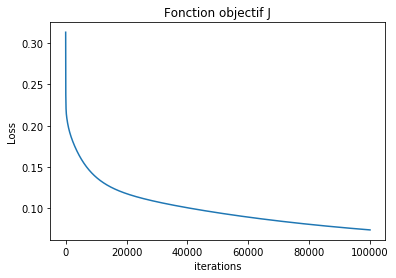

In [1095]:
# Entrainement du modele de regression
phi_x, W = entrainement(x_train, t_train, using_sklearn=False)

In [1096]:
W

0      5.576815
1    -13.609097
2     -2.834554
3      4.307373
4      6.413704
5      5.720186
6      3.907939
7      1.896555
8      0.121433
9     -1.244812
10    -2.162127
11    -2.652940
12    -2.765882
13    -2.557569
14    -2.083807
15    -1.395682
16    -0.538130
17     0.450259
18     1.536865
19     2.694425
dtype: float64

In [1097]:
# Predictions sur les ensembles 'entrainement et de test
predictions_train = prediction(phi_x)
predictions_test = prediction(x_test)
#predictions_train = np.array([prediction(x) for x in x_train])
#predictions_test = np.array([prediction(x) for x in x_test])

In [1098]:
# Calcul des erreurs
erreurs_entrainement = np.array([erreur(t_n, p_n)
                                 for t_n, p_n in zip(t_train, predictions_train)])
erreurs_test = np.array([erreur(t_n, p_n)
                         for t_n, p_n in zip(t_test, predictions_test)])

print("Erreur d'entraînement :", "%.2f" % erreurs_entrainement.mean())
print("Erreur de test :", "%.2f" % erreurs_test.mean())
print("")

warning(erreurs_test.mean(), erreurs_entrainement.mean(), bruit)

Erreur d'entraînement : 0.15
Erreur de test : 0.16



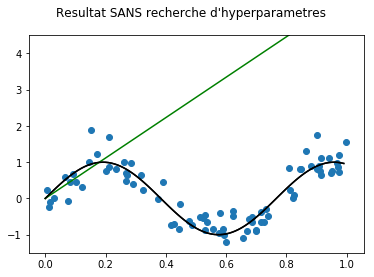

In [1099]:
afficher_donnees_et_modele(phi_x[0], t_train, True)
predictions_range = np.array([prediction(pd.DataFrame([x])) for x in np.arange(0, 1, 0.01)])
afficher_donnees_et_modele(np.arange(0, 1, 0.01), predictions_range, False)

if m >= 0:
    plt.suptitle('Resultat SANS recherche d\'hyperparametres')
else:
    plt.suptitle('Resultat AVEC recherche d\'hyperparametres')
plt.show()

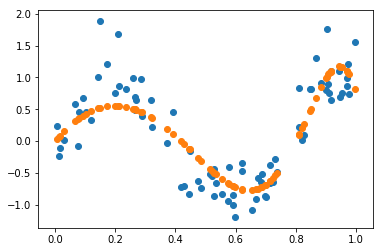

In [1100]:
plt.figure()
plt.scatter(x=pd.DataFrame(phi_x)[0],y= t_train)           
plt.scatter(x=pd.DataFrame(phi_x)[0], y=prediction(pd.DataFrame(phi_x)))
plt.show()